<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/genai/transformers_101_nmt_eng_hin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformers 101.

In this notebook we will create a transformer model using multi-headed attention for neural machine translation task.

A little bit about transformers, before we get started.
RNNs were traditionally used for modelling seq2seq tasks, however they fail when the length of the sequence of input increases. The attention mechanism was introduced with idea to identify the relative weights of each words with respect to the other words so that the model can learn selectively.

Attention technique used with RNNs help learn hidden state for each word so that it is easy to pay more attention or discard words rather than learning the hidden state for the entire sentence. However this does not solve 3 problems

1.   The entire process is still sequential, it cannot be parallelized
2.   For a large sentence the time taken for translating the sentence to encodings is large.

Transformers introduced a completely new concept, with some learnings from how CNNs learn embeddings in parallel. Transformers use encoder, decoder architecture to learn attention weights in parallel and they can be used for a variety of tasks like neural language translation, question answering, next word prediction etc.

Complete understanding of how transformers work is not explained in this notebook but you may refer to the following blogs for better understanding.
- https://jalammar.github.io/illustrated-transformer/
- https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XIWlzBNKjOR

This notebook builds a transformer model following the explanation from the original paper (https://arxiv.org/pdf/1706.03762.pdf). The implementation is taken from articles published at https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/.



In [211]:
## Importing required libraries

import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.keras import Model
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
import random
import re
import tqdm
import unicodedata
import tensorflow as tf
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle
import pandas as pd

## Transformers Architecture.

Image Source :  https://arxiv.org/pdf/1706.03762.pdf

We will use the bottom-up approach, i.e. build the transformer from the bottom most layer and then walk upwards. This notebook builds each layer as a separate model so that they can be plugged into a full fledged model.

## Download and Preprocess

In [212]:
!gdown 1HTlJZY18SRd4rSFbsbx9iW6XgA8Ms6mu

Downloading...
From: https://drive.google.com/uc?id=1HTlJZY18SRd4rSFbsbx9iW6XgA8Ms6mu
To: /content/eng-hin.csv
100% 56.9M/56.9M [00:00<00:00, 214MB/s]


In [213]:
ds = pd.read_csv('/content/eng-hin.csv')
print(f'Total number of examples = {len(ds)}')
ds.head()

Total number of examples = 177606


,Unnamed: 0,english_sentence,hindi_sentence
0,0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [214]:
ds['eng_len']=ds['english_sentence'].apply(lambda x:len(str(x).split(" ")))
ds['hin_len']=ds['hindi_sentence'].apply(lambda x:len(str(x).split(" ")))
ds.head()

,Unnamed: 0,english_sentence,hindi_sentence,eng_len,hin_len
0,0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",12,14
1,1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,9,11
2,2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,10,9
3,3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,12,11
4,4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,9,8


In [215]:
ds = ds[(ds['eng_len'] > 20) & (ds['eng_len'] < 200)]
ds = ds[(ds['hin_len'] > 20) & (ds['hin_len'] < 200)]
print(f'Total number of examples = {len(ds)}')

Total number of examples = 43162


In [216]:
ds['english_sentence'] = ds['english_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds['hindi_sentence'] = ds['hindi_sentence'].apply(lambda x: "[start] " + x + " [end]")
ds.head()

,Unnamed: 0,english_sentence,hindi_sentence,eng_len,hin_len
8,8,[start] “”Global Warming“” refer to warming ca...,[start] ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों...,22,30
9,9,[start] You may want your child to go to a sch...,[start] हो सकता है कि आप चाहते हों कि आप का नऋ...,34,39
15,15,[start] They had justified their educational p...,[start] कम संख़्या वाले उच्च एवं मध्यम श्रेणी ...,36,38
18,18,"[start] ii Register Courts , empowered to try ...",[start] रजिस्टर न्यायालय जिन्हें न्यायाधीश द्व...,21,22
19,19,[start] Extreme weather due to increased morta...,[start] बढ़ती हुई मौतों displacements और आर्थि...,33,50


In [217]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
ds['english_sentence']=ds['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))
ds['hindi_sentence']=ds['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))

In [218]:
# ds = ds.sample(frac=0.1).reset_index(drop=True)
# len(ds)
def normalize(eng, hin):
    """Normalize a line of text and split into two at the tab character"""
    line = str(eng.strip().lower()) + "\t" + str(hin.strip())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, hind = line.split('\t')
    return eng, hin

text_pairs = []
for index in ds.index:
    text_pairs.append(normalize(ds['english_sentence'][index], ds['hindi_sentence'][index]))
print(len(text_pairs))

43162


## Parameters

In [219]:
n_sentences = 5000
batch_size=64

if n_sentences is None:
    text_pairs = text_pairs[:]
else:
    text_pairs = text_pairs[:n_sentences]

In [220]:
# Create train, val and testing datasets
val_split = 0.15

# shuffle
# ds = ds.sample(frac = 1)
len_text_pairs = len(text_pairs)
n_val_index = int(val_split * len_text_pairs)
n_train_index = len_text_pairs - 2 * n_val_index

train_tp = text_pairs[:n_train_index]
test_tp = text_pairs[n_train_index:n_train_index + n_val_index]
val_tp = text_pairs[n_train_index + n_val_index:]
print(f"Train: {len(train_tp)}")
print(f"Validation: {len(val_tp)}")
print(f"Test: {len(test_tp)}")

Train: 3500
Validation: 750
Test: 750


In [221]:
train_tp[:3]

[('start  “ ”global warming“ ” refer to warming caused in recent decades and probability of its continual presence and its indirect effect on human being end',
  'start ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई वार्मिंग और इसके निरंतर बने रहने के अनुमान और इसके अप्रत्यक्ष रूप से मानव पर पड़ने वाले प्रभाव से है। end'),
 ("start you may want your child to go to a school that is not run by the lea  a nonmaintained special school or an independent school that can meet your child  ' s needs  end",
  'start हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटेन्ड ह्यबिना किसी समर्थन के हृ विशेष स्कूल  या किसी स्वतंत्र स्कूल में जाए  इजसके पास विशेष शैक्षणिक जऋऋरतों वाले बच्चों के प्रति सहूलियत हों   end'),
 ("start they had justified their educational policy of concentrating on the education of a small number of upper and middleclass people with the argument that the new education would gradually  ' filter down  ' from above  end",
  'start कम संख़्या वाले उच्च एवं मध्यम श्रेणी के लोगों तक ही 

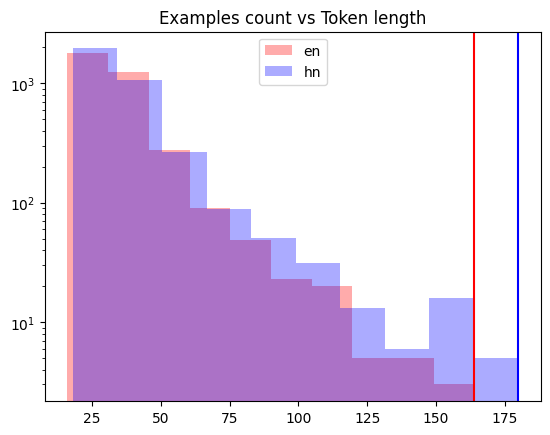

In [222]:
# histogram of sentence length in tokens
en_lengths = [len(e.split()) for e, h in train_tp]
hn_lengths = [len(h.split()) for e, h in train_tp]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(hn_lengths, label="hn", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(hn_lengths), max(hn_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [223]:
 # count tokens
eng_tokens, hin_tokens = set(), set()
eng_maxlen, hin_maxlen = 0, 0
for eng, hin in text_pairs:
    eng_tok, hin_tok = eng.split(), hin.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(hin_maxlen, len(hin_tok))
    eng_tokens.update(eng_tok)
    hin_tokens.update(hin_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total Hindi tokens: {len(hin_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max Hindi length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")
vocab_size_en = len(eng_tokens)
vocab_size_hn = len(hin_tokens)

Total English tokens: 19306
Total Hindi tokens: 23141
Max English length: 192
Max Hindi length: 28
5000 total pairs


In [224]:
seq_length = 50

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
hin_vectorizer = TextVectorization(
    max_tokens=vocab_size_hn,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)


## Prepare dataset

In [225]:
train_eng_texts = [pairs[0] for pairs in train_tp]
train_hin_texts = [pairs[1] for pairs in train_tp]

eng_vectorizer.adapt(train_eng_texts)
hin_vectorizer.adapt(train_hin_texts)

# set up Dataset object
def format_dataset(eng, hin):
    eng = eng_vectorizer(eng)
    hin = hin_vectorizer(hin)
    source = (eng, hin[:, :-1])
    target = hin[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, hin_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(hin_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_tp)
val_ds = make_dataset(val_tp)

In [226]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs[0].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs[0][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs[1].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs[1][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 50)
inputs["encoder_inputs"][0]: [    6  1161     2 13746     3     2   276     4     3     2   505    89
  1711     9  1194  2818    61  2463   108    17     9   471  1263     3
    40   447   376   483    12     9  9222     3     2   460     3     2
   159    59    33   806   169     3   898    87     4    29  7802  5763
  2876     5]
inputs["decoder_inputs"].shape: (64, 50)
inputs["decoder_inputs"][0]: [    4   300    30  1218     2  9270     3    15   144   566   230    99
   225    39    50    16  1489    51   623   252     2   717     9   794
   139     6   865   832     2    46     8   421 13934  4432 14332 14345
  9423    64   561   296   774   139     2  2138    13   165     6  1950
    13 12596]
targets.shape: (64, 50)
targets[0]: [  300    30  1218     2  9270     3    15   144   566   230    99   225
    39    50    16  1489    51   623   252     2   717     9   794   139
     6   865   832     2    46     8   421 13934  4432 14332 14345

In [227]:
eng_lookup = list(eng_vectorizer.get_vocabulary())
hin_lookup = list(hin_vectorizer.get_vocabulary())
eng_sen, hin_sen, hin_source = "", "",""
print(inputs[1].shape)
for index in inputs[0][0]:
  eng_sen += eng_lookup[index.numpy()] + " "
for index in targets[0]:
  hin_source += hin_lookup[index.numpy()] + " "
print(f"source: {eng_sen}")
print(f"hin source: {hin_source}")

(64, 50)
source: start 6 the constitutions of the union and of the groups should contain a provision whereby any province could by a majority vote of its legislative assembly call for a reconsideration of the terms of the constitution after an initial period of ten years and at tenyearly intervals thereafter end 
hin source: संघ तथा समूहों के संविधानों में एक ऐसा उपबंध होना चाहिए जिसके द्वारा कोई भी प्रांत अपनी विधान सभा के बहुमत से 10 वर्ष की प्रारंभिक अवधि के बाद और 1 त्रितलीय ढांचा ठ्ह्रेए ठिएर् श्ट्रुच्टुरे उसके पश्चात प्रत्येक दस वर्ष के अंतराल पर संविधान की शर्तों पर पुनर्विचार करने 


## Vocab size

In [228]:
# find out how many distinct tokens exist
print(f"Total English tokens = {vocab_size_en}.")
print(f"Total Hindi tokens = {vocab_size_hn}.")

Total English tokens = 19306.
Total Hindi tokens = 23141.


In [229]:
for (eng, hin), hn_labels in train_ds.take(1):
  break
print(eng.shape)
print(hin.shape)
print(hn_labels.shape)

print(hin[0][:10])
print(hn_labels[0][:10])

(64, 50)
(64, 50)
(64, 50)
tf.Tensor([    4   354   981   251 15743    13 15956  4810 11698   262], shape=(10,), dtype=int64)
tf.Tensor([  354   981   251 15743    13 15956  4810 11698   262     2], shape=(10,), dtype=int64)


## Positional Embedding Layer



In [230]:
# Positional embedding matrix - This matrix represents the position of the word in the sentence.
# It takes input as length of the sentence and size of the vector embeddings
# The output is a matrix where every row is a word in the sentence, each row represents the position encoding of that word
# The length of each row is equal to the length of word embeddings.
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_matrix = positional_encoding(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]], shape=(4, 4), dtype=float32)


In [231]:
# Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [232]:
eng_pos = PositionalEmbedding(vocab_size_en, 512)
hin_pos = PositionalEmbedding(vocab_size_hn, 512)
print(eng_pos(eng).shape)
print(hin_pos(hin).shape)

(64, 50, 512)
(64, 50, 512)



## Self Attention Layer

In [233]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [234]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
enc_output = eng_pos(eng)
print(enc_output.shape)
print(sample_gsa(enc_output).shape)

(64, 50, 512)
(64, 50, 512)


## Cross Attention Layer

In [235]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [236]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
emb_output_hin = hin_pos(hin)
print(emb_output_eng.shape)
print(emb_output_hin.shape)
print(sample_ca(emb_output_eng, emb_output_hin).shape)

(64, 50, 512)
(64, 50, 512)
(64, 50, 512)


## Causal Self Attention

In [237]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [238]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
print(emb_output_eng.shape)
print(sample_csa(emb_output_eng).shape)

(64, 50, 512)
(64, 50, 512)


## Feedforward Layer

In [239]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [240]:
sample_ffn = FeedForward(512, 2048)
print(sample_ffn(emb_output_eng).shape)

(64, 50, 512)


## Encoder

In [241]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [242]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(emb_output_eng.shape)
print(sample_encoder_layer(emb_output_eng).shape)

(64, 50, 512)
(64, 50, 512)


In [243]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`.

In [244]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_en)
sample_encoder_output = sample_encoder(eng, training=False)
print(eng.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 50)
(64, 50, 512)


## Decoder

In [245]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [246]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [247]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_hn)
output = sample_decoder(x=hin,context=emb_output_eng)
# Print the shapes.
print(hin.shape)
print(emb_output_hin.shape)
print(output.shape)

(64, 50)
(64, 50, 512)
(64, 50, 512)


In [248]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 50, 50])

## Transformer Model

In [249]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training Utilities

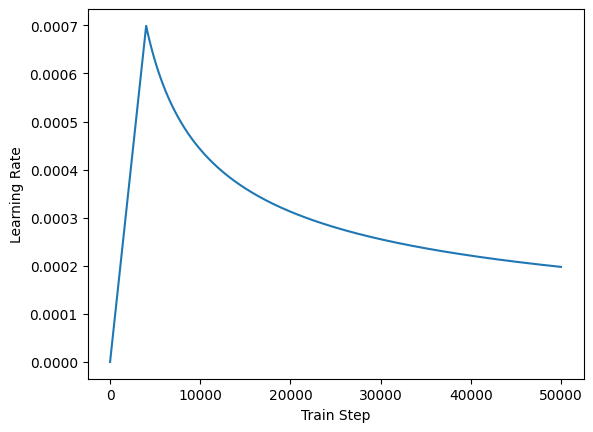

In [250]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

key_dim = 512
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [251]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [252]:
# Parameters
n_sentences = None
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1

In [253]:
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_en,
    target_vocab_size=vocab_size_hn,
    dropout_rate=dropout_rate)
lr = CustomSchedule(512)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


## Training

Epoch 1/30
55/55 [==============================] - 80s 1s/step - loss: 9.9270 - masked_accuracy: 0.0173 - val_loss: 9.6631 - val_masked_accuracy: 0.0451
Epoch 2/30
55/55 [==============================] - 51s 936ms/step - loss: 9.4885 - masked_accuracy: 0.0431 - val_loss: 9.2856 - val_masked_accuracy: 0.0452
Epoch 3/30
55/55 [==============================] - 52s 948ms/step - loss: 9.0250 - masked_accuracy: 0.0431 - val_loss: 8.7680 - val_masked_accuracy: 0.0452
Epoch 4/30
55/55 [==============================] - 52s 941ms/step - loss: 8.4116 - masked_accuracy: 0.0458 - val_loss: 8.1712 - val_masked_accuracy: 0.0603
Epoch 5/30
55/55 [==============================] - 52s 941ms/step - loss: 7.8001 - masked_accuracy: 0.0609 - val_loss: 7.6883 - val_masked_accuracy: 0.0638
Epoch 6/30
55/55 [==============================] - 52s 943ms/step - loss: 7.4095 - masked_accuracy: 0.0640 - val_loss: 7.4959 - val_masked_accuracy: 0.0669
Epoch 7/30
55/55 [==============================] - 52s 945ms

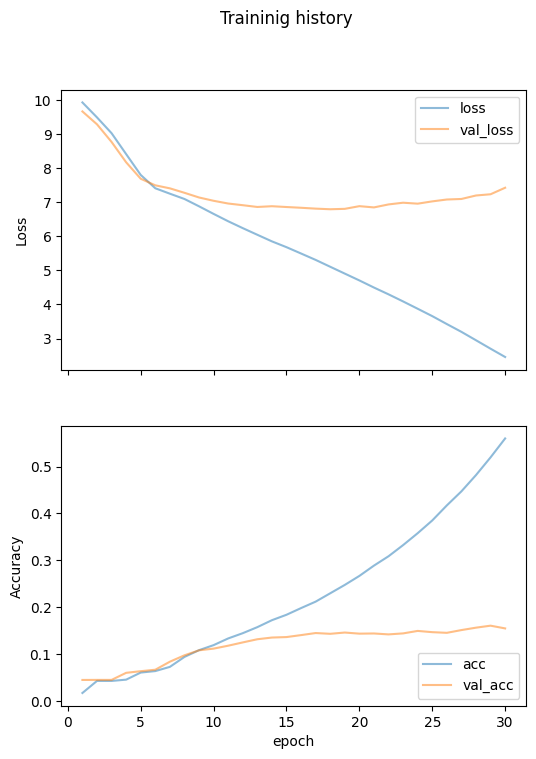

In [254]:
epochs = 30
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

In [255]:
# training parameters used
seq_len = 20
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(hin_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = hin_vectorizer([" ".join(output_sentence)])
        dec_tokens = vector[:, :-1]
        pred = model([enc_tokens, dec_tokens])
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 5
for n in range(test_count):
    english_sentence, Hindi_sentence = random.choice(val_tp)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {Hindi_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

NameError: ignored